# Wine Quality ML
source : https://www.kaggle.com/rajyellow46/wine-quality

## Download Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"aisudev","key":"94b743e8aaed000695c7b1cc0c261a92"}'}

In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 kaggle.json
! kaggle datasets download -d rajyellow46/wine-quality
! unzip wine-quality.zip

wine-quality.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  wine-quality.zip
replace winequalityN.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: winequalityN.csv        


In [ ]:
import pandas as pd
wine = pd.read_csv('/content/winequalityN.csv')

## EDA

In [ ]:
wine.columns = wine.columns.str.replace(' ','_')
wine.columns = wine.columns.str.lower()
wine.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   ph                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [ ]:
wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Cleaning Data

In [ ]:
wine.isna().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
ph                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [ ]:
wine.fillna(wine.mean(), inplace=True)

### Correlation

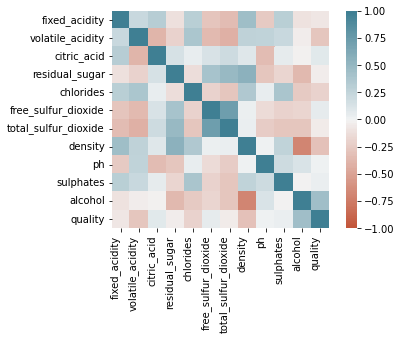

In [ ]:
import seaborn as sns

ax = sns.heatmap(
    wine.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

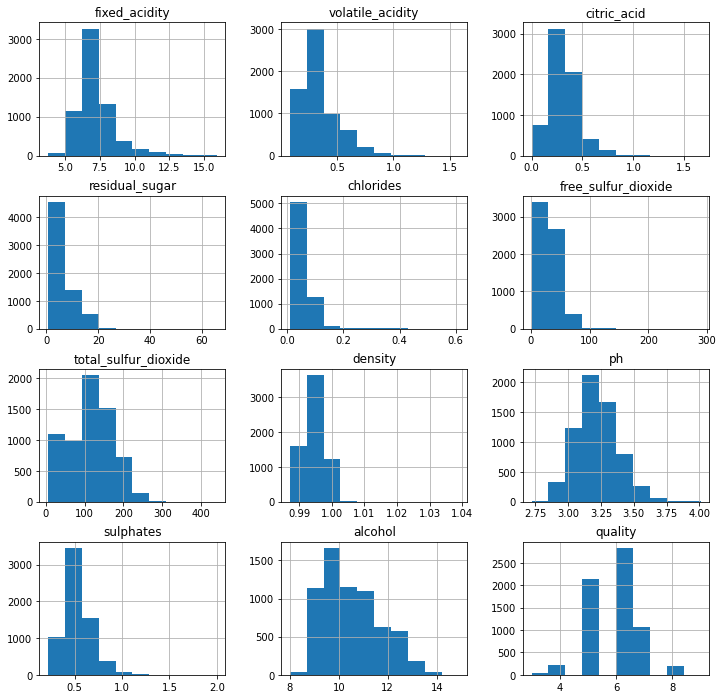

In [ ]:
import matplotlib.pyplot as plt
wine.hist(figsize=(12, 12))
plt.show()

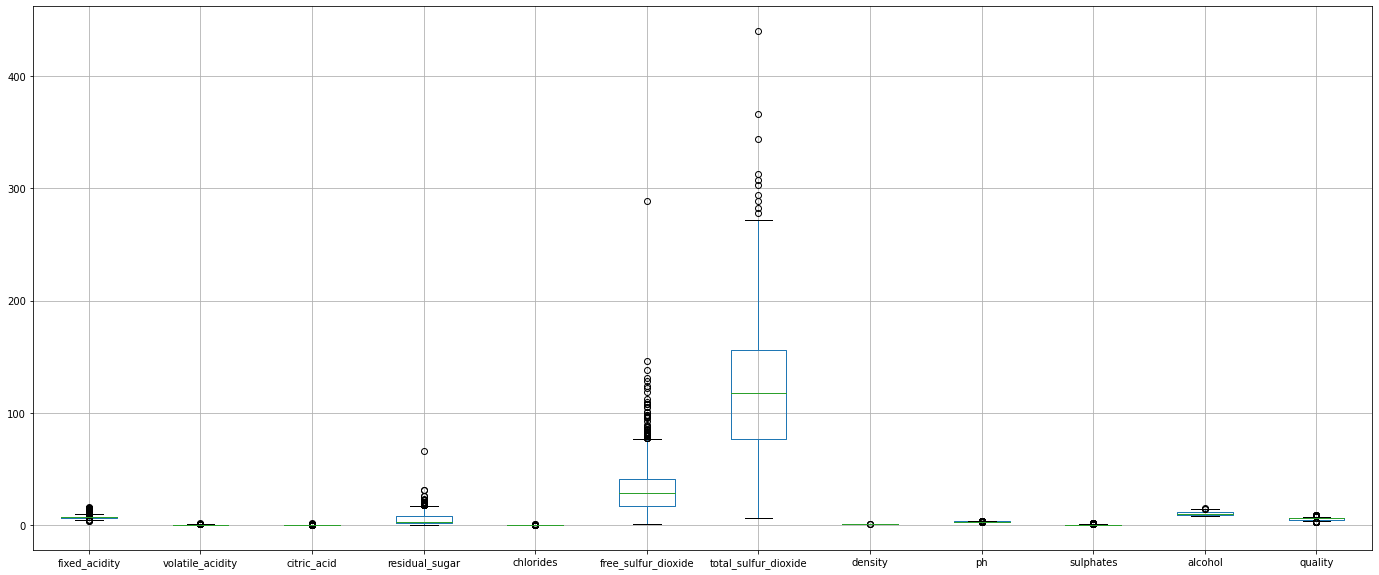

In [ ]:
wine.boxplot(figsize=(24, 10))
plt.show()

## Preprocessing

### One-Hot Encoder Wine type

#### Unique Wine Type

In [ ]:
pd.unique(wine.type)

array(['white', 'red'], dtype=object)

#### Encoder

In [ ]:
encode_type = pd.get_dummies(wine['type'], prefix='type')
wine = pd.concat([encode_type, wine], axis=1)
wine.drop(['type', 'type_red'], axis=1, inplace=True)
wine.head()

,type_white,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Initial Quality Level

In [ ]:
def findQualityLevel(q):
  if q > 6:
    return 'good'
  elif q > 3:
    return 'normal'
  else:
    return 'bad'

In [ ]:
quality_level = []
for ind, row in wine.iterrows():
    quality_level.append(findQualityLevel(row['quality']))

wine['quality_level'] = quality_level
wine.drop(['quality'], inplace=True, axis=1)
wine.head()

,type_white,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_level
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,normal
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,normal
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,normal
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,normal
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,normal


### Seperate to Train and Test Set

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

x = np.array(wine.iloc[:, :-1])
y = np.array(wine.iloc[:, -1:]).reshape(-1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, shuffle=True, random_state=42)
print('Train Set Shape:', x_train.shape, y_train.shape)
print('Test Set Shape:', x_test.shape, y_test.shape)

Train Set Shape: (4547, 12) (4547,)
Test Set Shape: (1950, 12) (1950,)


### Outlier Handle

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
y_hat = lof.fit_predict(x_train)
mask = y_hat != -1
x_train = x_train[mask, :]
y_train = y_train[mask]
print('Train Set /w Handle Outlier Shape:', x_train.shape, y_train.shape)

Train Set /w Handle Outlier Shape: (4484, 12) (4484,)


## Modeling

In [ ]:
from sklearn.metrics import accuracy_score

### K-Nearest-Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(x_test)
y_pred


array(['good', 'normal', 'good', ..., 'good', 'normal', 'normal'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.7887179487179488

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf')
svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svc.predict(x_test)
y_pred


array(['normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.8025641025641026

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = dt.predict(x_test)
y_pred

array(['good', 'normal', 'good', ..., 'good', 'normal', 'normal'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.8184615384615385

### Ensemble

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

#### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(x_test)
y_pred

array(['good', 'normal', 'normal', ..., 'good', 'normal', 'normal'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.8830769230769231

#### Extra Tree

In [ ]:
et = ExtraTreesClassifier()
et.fit(x_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
y_pred = et.predict(x_test)
y_pred

array(['good', 'normal', 'normal', ..., 'good', 'normal', 'normal'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.877948717948718

In [ ]:
ada = AdaBoostClassifier()
ada.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
y_pred = ada.predict(x_test)
y_pred

array(['good', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.7830769230769231

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = gb.predict(x_test)
y_pred

array(['normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.8328205128205128

## Best Modeling

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
forest = RandomForestClassifier()
cv = KFold(n_splits=5)

In [ ]:
params = {
    'n_estimators': [10, 30, 60, 100],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [70]:
grid = GridSearchCV(forest, params, scoring='accuracy', cv=cv, return_train_score=True, verbose=2)

In [71]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=10 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=30 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_features=sqrt, n_estimators=30 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_features=sqrt, n_estimators=30 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_features=sqrt, n_estimators=30 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_features=sqrt, n_estimators=30 ..............

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   30.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=60, n_jobs=None,
                                              oob_sc

In [72]:
grid.best_score_

0.8733245242076764

In [73]:
grid.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 30}

In [74]:
forest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=60, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
y_pred = forest.predict(x_test)
y_pred

array(['good', 'normal', 'normal', ..., 'good', 'normal', 'normal'],
      dtype=object)

In [76]:
accuracy_score(y_test, y_pred)

0.8733333333333333